# Singular Value Decomposition

Z. W. Miller - Copyright 2018

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [3]:
import numpy as np
import pandas as pd

class svd:
    
    def __init__(self, n_components=None):
        """
        singular value decomposition breaks an input matrix
        into three sub-matrices that when multiplied together
        approximate the original. By truncating how many components
        we allow in the three matrices, we can remove dimensions
        while still capturing as much variance as possible. The
        three sub matrices are tradtionally called U, Sigma, and V.
        ---
        KWargs:
        n_components: how many components to have after dim. 
        reduction (int)
        """
        self.n_components = n_components
        
    def fit(self, X):
        """
        SVD is done by finding the eigenvalues and vectors
        for X^T*X and X*X^T. V is made of the eigenvectors
        from X^T*X, U from X*X^T, and sigma is made of the 
        square roots of the unique eigenvalues. 
        
        U is a representation of each row in X in the low
        dimensional space. V is a representation of each 
        column in X in the low dimensional space. 
        
        We'll truncate U, Sigma, and V to the n_components
        to reduce the dimensionality. Note that sigma also
        contains eigenvalues so we can use that to find the
        explained variance.
        ---
        Input: X, data matrix (dataframe, array, list of lists)
        """
        X = self.convert_to_array(X)
        
        XTX = np.dot(X.T, X)
        XTX_eigenvals, XTX_eigenvecs = self.get_eigenvalues_and_eigenvectors(XTX)
        self.sigma = np.sqrt(np.abs(XTX_eigenvals))
        self.V = XTX_eigenvecs.T
        
        XXT = np.dot(X, X.T)
        XXT_eigenvals, XXT_eigenvecs = self.get_eigenvalues_and_eigenvectors(XXT)
        self.U = XXT_eigenvecs[:,:self.V.shape[0]]
        # We only took the same number of columns as V has rows. That's because
        # without doing this, U is a square matrix with shape (len(X), len(X)).
        # We're not interested in all the junk beyond the columns that matter
        # for our reconstruction.
        
        if self.n_components:
            self.V = self.V[:self.n_components,:]
            self.sigma = self.sigma[:self.n_components]
            self.U = self.U[:,:self.n_components]
        
        self.explained_variance = np.flip(self.sigma/np.sum(self.sigma), axis=0)
    
    def get_eigenvalues_and_eigenvectors(self, mat):
        """
        Use the built in eigen extractor from numpy.
        Based on LAPACK eigen solver.
        """
        eigenvalues, eigenvectors = np.linalg.eigh(mat)
        indices = np.argsort(np.abs(eigenvalues)) # smallest to largest
        indices = np.flip(indices, axis=0) # largest to smallest
        eigenvals = eigenvalues[indices]
        eigenvectors = eigenvectors[:,indices]
        return eigenvalues, eigenvectors
        
    def transform(self, X):
        """
        Since V is a conversion of columns to the lower
        dimensional space, we can just use matrix 
        multiplication to cast any new data into that 
        space.
        ---
        Input: X, data matrix (dataframe, array, list of lists)
        """
        X = self.convert_to_array(X)
        return np.dot(X, self.V.T)
    
    def fit_transform(self, X):
        """
        Fits and Transforms the data returning the
        representation of the training data in the
        lower dimensional space.
        """
        self.fit(X)
        return self.transform(X)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

# Simple dataset to make sure it's working

In [4]:
from sklearn.datasets import load_iris

X = load_iris().data
dr = svd(n_components=3)
dr.fit(X)

In [5]:
dr.U.shape

(150, 3)

In [6]:
dr.explained_variance

array([ 0.76818641,  0.15037373,  0.08143987])

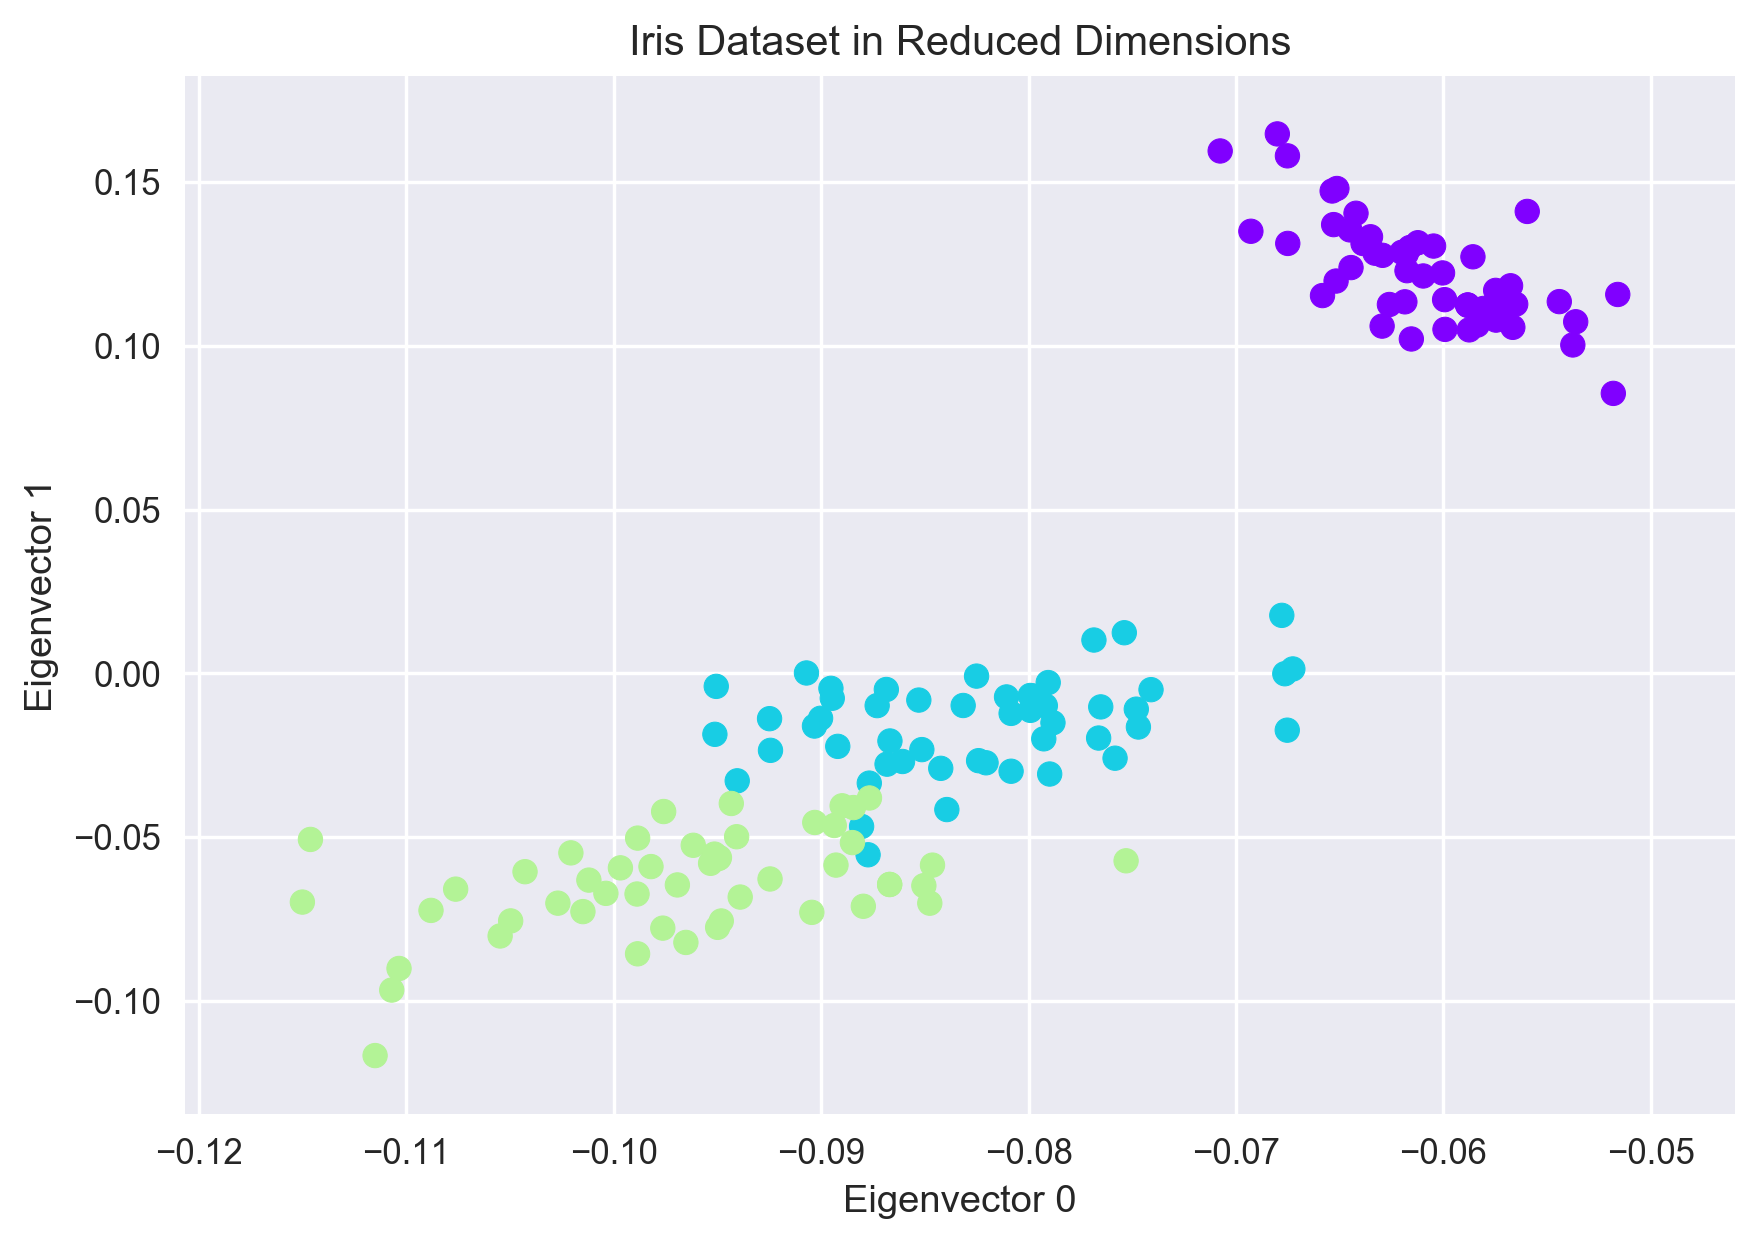

In [7]:
plt.figure(dpi=250)
plt.scatter(dr.U[:,0], dr.U[:,1], c=plt.cm.rainbow(0.3*load_iris().target))
plt.title("Iris Dataset in Reduced Dimensions")
plt.xlabel("Eigenvector 0")
plt.ylabel("Eigenvector 1");

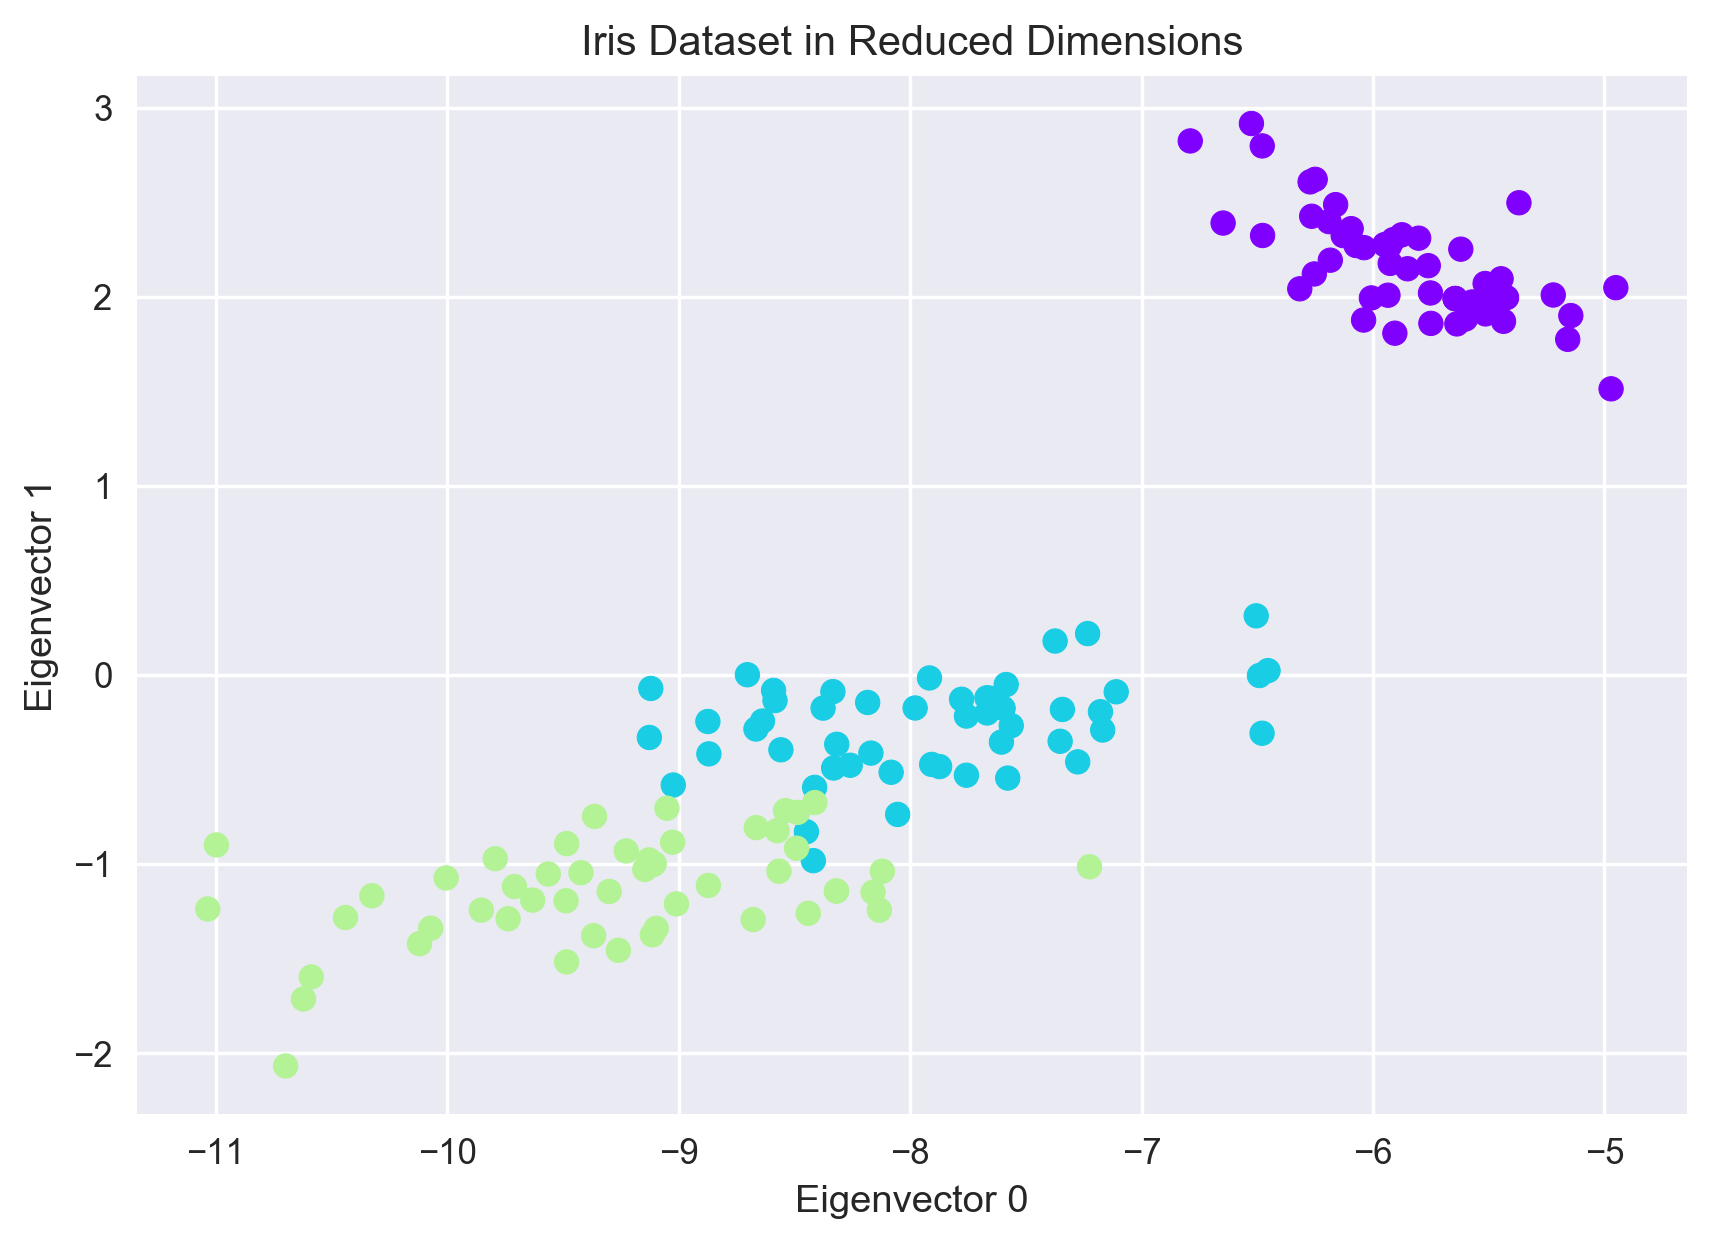

In [8]:
preds = dr.transform(X)
plt.figure(dpi=250)
plt.scatter(preds[:,0], preds[:,1], c=plt.cm.rainbow(0.3*load_iris().target))
plt.title("Iris Dataset in Reduced Dimensions")
plt.xlabel("Eigenvector 0")
plt.ylabel("Eigenvector 1");

In [9]:
from sklearn.decomposition import TruncatedSVD

sksv = TruncatedSVD(n_components=3)
sksv.fit(X)
skpred = sksv.transform(X)

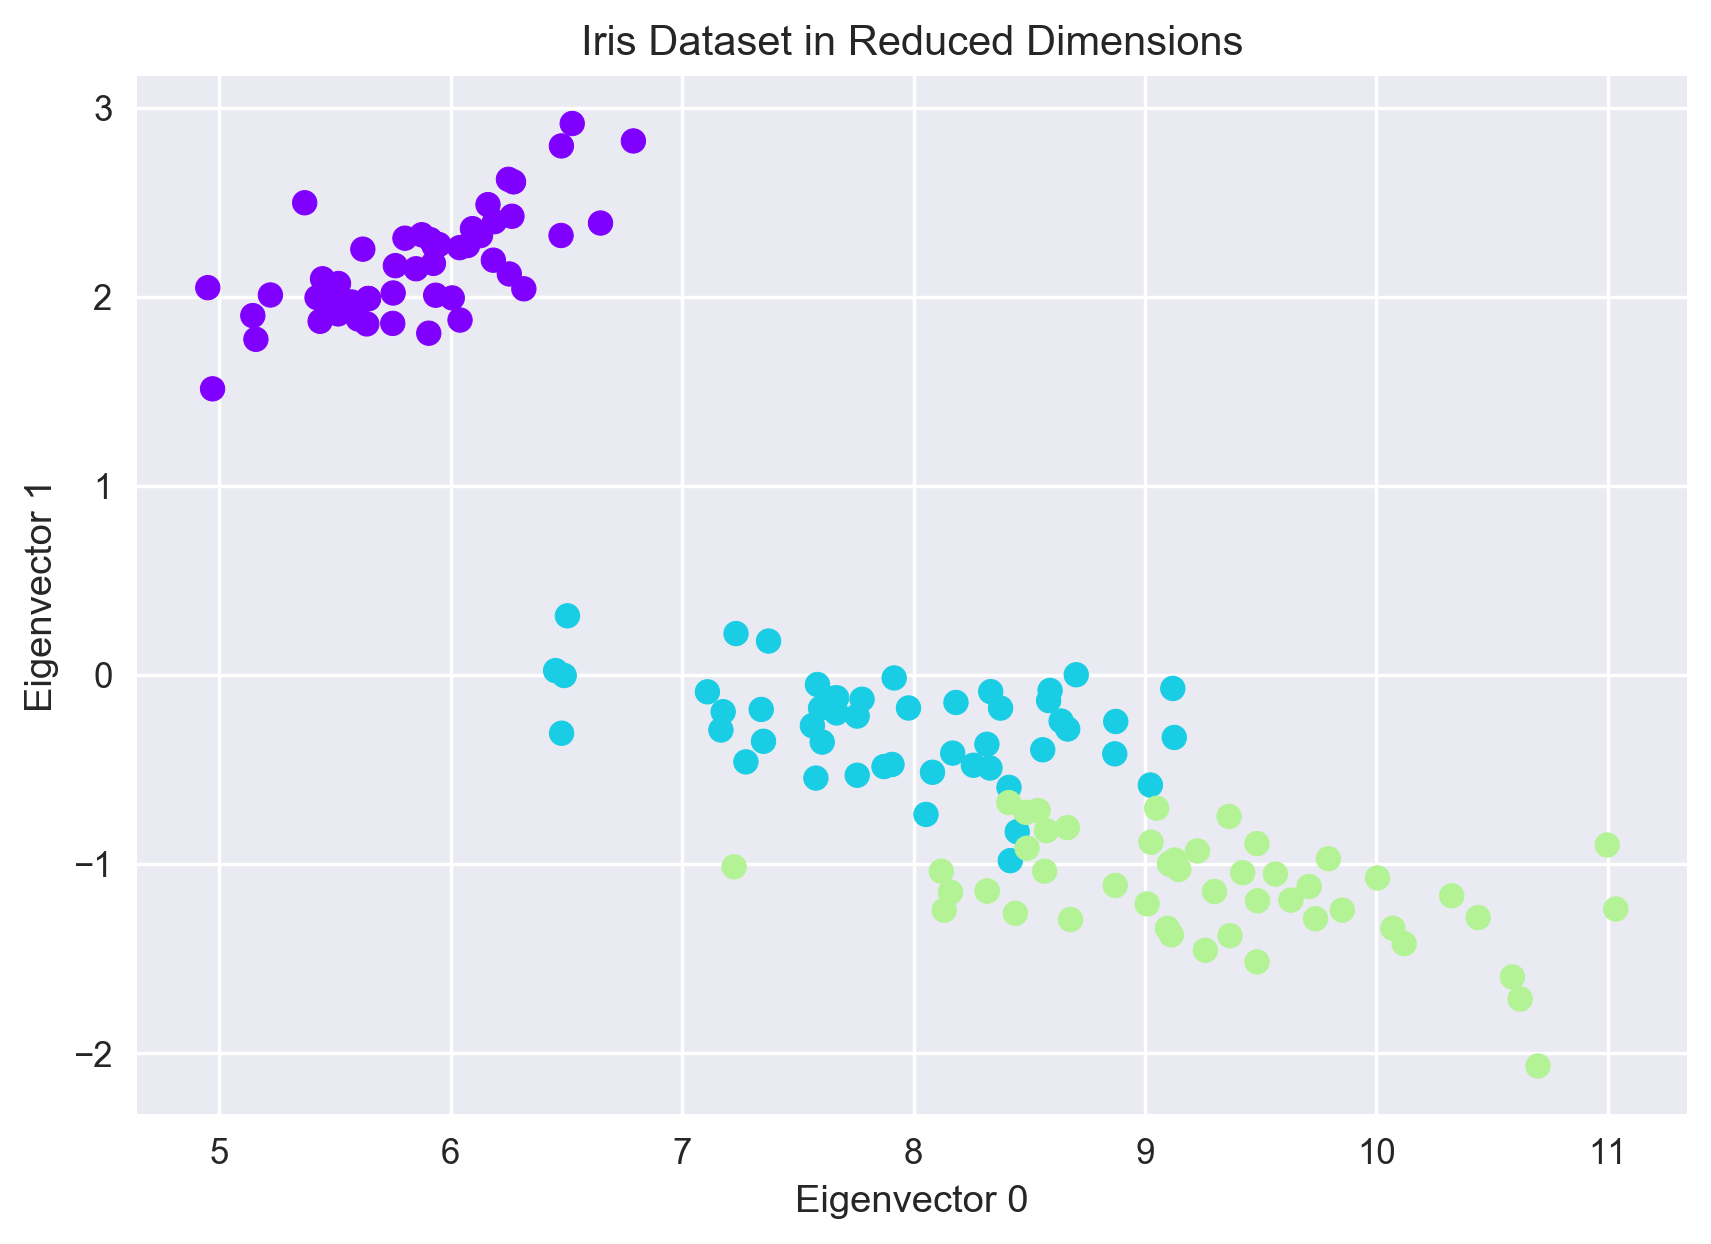

In [10]:
plt.figure(dpi=250)
plt.scatter(skpred[:,0], skpred[:,1], c=plt.cm.rainbow(0.3*load_iris().target))
plt.title("Iris Dataset in Reduced Dimensions")
plt.xlabel("Eigenvector 0")
plt.ylabel("Eigenvector 1");

In [11]:
# adjust due to flipped direction in eigenvectors (it doesn't matter unless you're comparing)
skpred[:,0] = -skpred[:,0]
skpred[:,2] = -skpred[:,2]

In [12]:
np.allclose(preds, skpred)

True